In [73]:
import cv2
import numpy as np
from PIL import Image 
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import argparse
import datetime
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.cluster import MeanShift, estimate_bandwidth
import math
import random
from scipy.spatial import distance
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Image 4


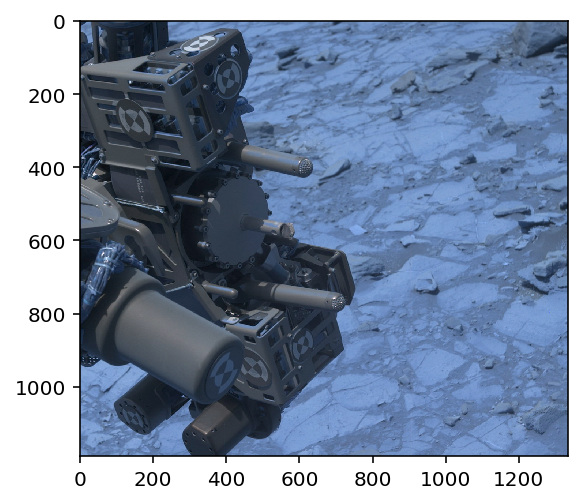

In [74]:
#input of the image
whatimg=int(input("Image"))
if whatimg==1:
    img = cv2.imread('image1.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-15,170:width-180]
    plt.imshow(Img)
elif whatimg==2:
    img = cv2.imread('image2.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-10,10:width-10]
    plt.imshow(Img)
elif whatimg==3:
    img = cv2.imread('image3.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-15,170:width-180]
    plt.imshow(Img)
elif whatimg==4:
    img = cv2.imread('image4.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-10,10:width-10]
    plt.imshow(Img)

Color Mode(RGB,HSV,Lab,yCrCb,XYZ,LUV,YUV,gray): HSV


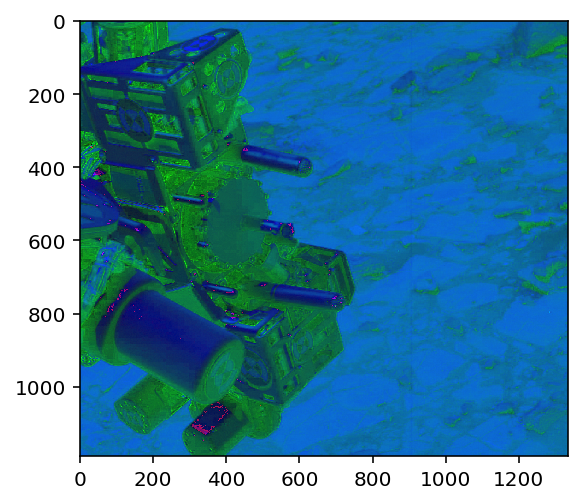

In [77]:
#color space transformation
colorsp=input("Color Mode(RGB,HSV,Lab,yCrCb,XYZ,LUV,YUV,gray):")
if colorsp=="RGB":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB )
    plt.imshow(Imag)
elif colorsp=="HSV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV )
    plt.imshow(Imag)
elif colorsp=="Lab":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2LAB )
    plt.imshow(Imag)
elif colorsp=="yCrCb":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2YCrCb)
    plt.imshow(Imag)
elif colorsp=="XYZ":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2XYZ)
    plt.imshow(Imag)   
elif colorsp=="LUV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2LUV)
    plt.imshow(Imag)
elif colorsp=="YUV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2YUV)
    plt.imshow(Imag)
elif colorsp=="gray":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    plt.imshow(Imag) 

In [9]:
from skimage import data, segmentation, filters, color,io
from skimage.future import graph
from matplotlib import pyplot as plt
from plot_boundary_merge import weight_boundary, merge_boundary

In [51]:
def decorrstretch(A, tol=None):
    """
    Apply decorrelation stretch to image
    Arguments:
    A   -- image in cv2/numpy.array format
    tol -- upper and lower limit of contrast stretching
    """

    # save the original shape
    orig_shape = A.shape
    # reshape the image
    #         B G R
    # pixel 1 .
    # pixel 2   .
    #  . . .      .
    A = A.reshape((-1,3)).astype(np.float)
    # covariance matrix of A
    cov = np.cov(A.T)
    # source and target sigma
    sigma = np.diag(np.sqrt(cov.diagonal()))
    # eigen decomposition of covariance matrix
    eigval, V = np.linalg.eig(cov)
    # stretch matrix
    S = np.diag(1/np.sqrt(eigval))
    # compute mean of each color
    mean = np.mean(A, axis=0)
    # substract the mean from image
    A -= mean
    # compute the transformation matrix
    T = reduce(np.dot, [sigma, V, S, V.T])
    # compute offset 
    offset = mean - np.dot(mean, T)
    # transform the image
    A = np.dot(A, T)
    # add the mean and offset
    A += mean + offset
    # restore original shape
    B = A.reshape(orig_shape)
    # for each color...
    for b in range(3):
        # apply contrast stretching if requested
        if tol:
            # find lower and upper limit for contrast stretching
            low, high = np.percentile(B[:,:,b], 100*tol), np.percentile(B[:,:,b], 100-100*tol)
            B[B<low] = low
            B[B>high] = high
        # ...rescale the color values to 0..255
        B[:,:,b] = 255 * (B[:,:,b] - B[:,:,b].min())/(B[:,:,b].max() - B[:,:,b].min())
    # return it as uint8 (byte) image
    return B.astype(np.uint8)

In [52]:
image_destre=decorrstretch(Imag, tol=None)

Text(0.5, 1.0, 'yCrCb image')

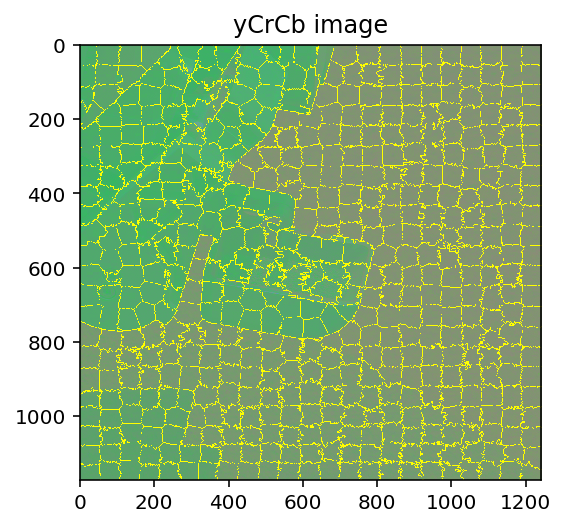

In [8]:
labels = segmentation.slic(image_destre, compactness=10, n_segments=500)#create the over-segmentation
plt.imshow(segmentation.mark_boundaries(image_destre,labels))
plt.title("yCrCb image")

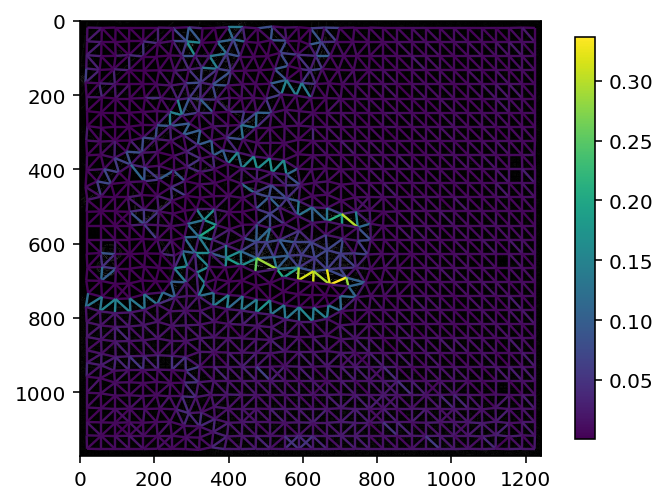

In [33]:
gimg = color.rgb2gray(Imag)#in order to calculate the gradient density

labels = segmentation.slic(Imag, compactness=30, n_segments=1000)#create the over-segmentation
edges = filters.sobel(gimg)
edges_rgb = color.gray2rgb(edges)

g = graph.rag_boundary(labels, edges)#gives the significance of the edges at each pixel
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis',
                    edge_width=1.2)

plt.colorbar(lc, fraction=0.03)
io.show()


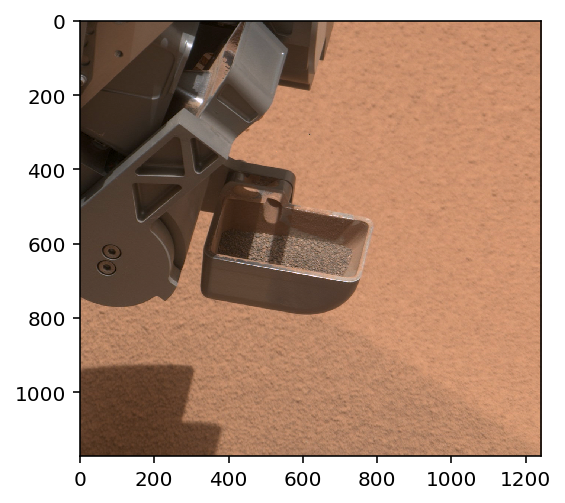

In [37]:
plt.imshow(Imag)

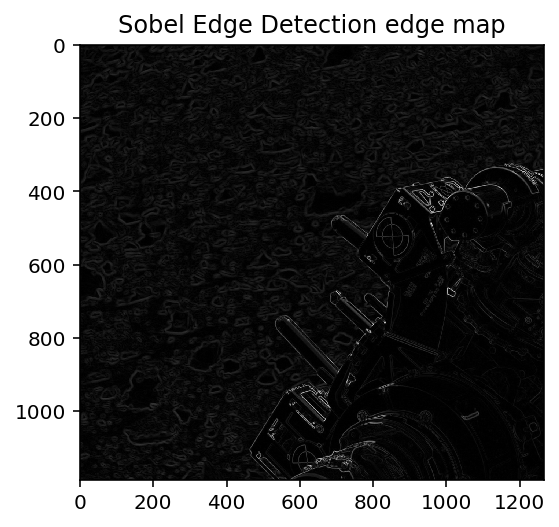

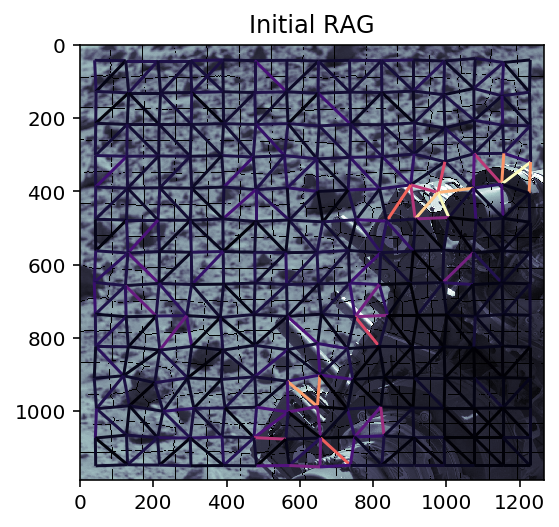

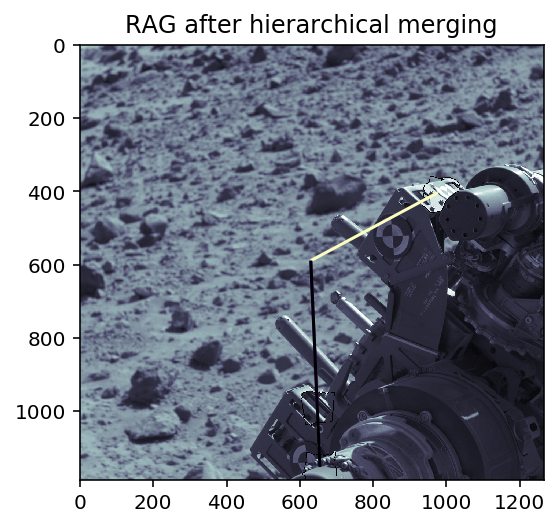

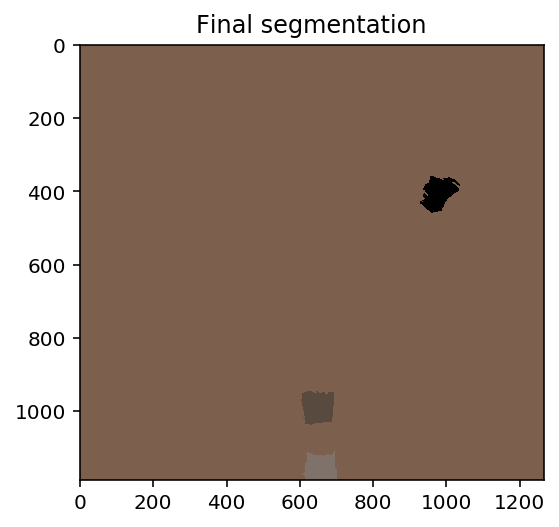

In [66]:
#sobel-operator region-based RAG/slic oversegmentation
image1=np.copy(Imag)
#image1 = filters.gaussian(image1, sigma=3, multichannel=True)
#plt.imshow(Imag)
edges = filters.sobel(color.rgb2gray(image1))#find edges in an image using sobel operator
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Sobel Edge Detection edge map')
labels = segmentation.slic(image1, compactness=100, n_segments=200,sigma=0.1)
g = graph.rag_boundary(labels, edges)

graph.show_rag(labels, g, image1)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(labels, g, thresh=0.07, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

graph.show_rag(labels, g, image1)
plt.title('RAG after hierarchical merging')

plt.figure()
out = color.label2rgb(labels2, image1, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Final segmentation')

plt.show()
#start_label problem

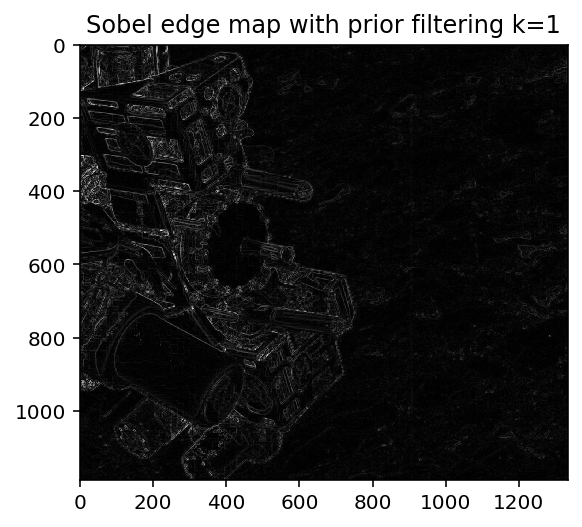

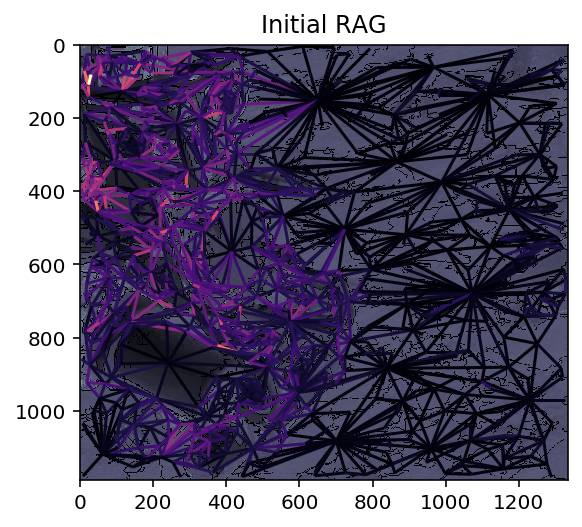

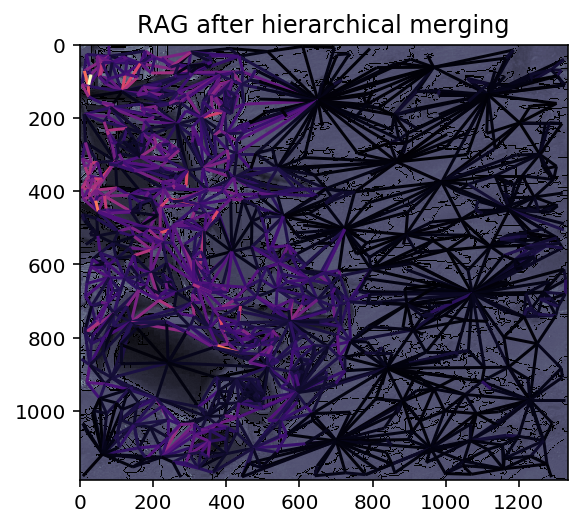

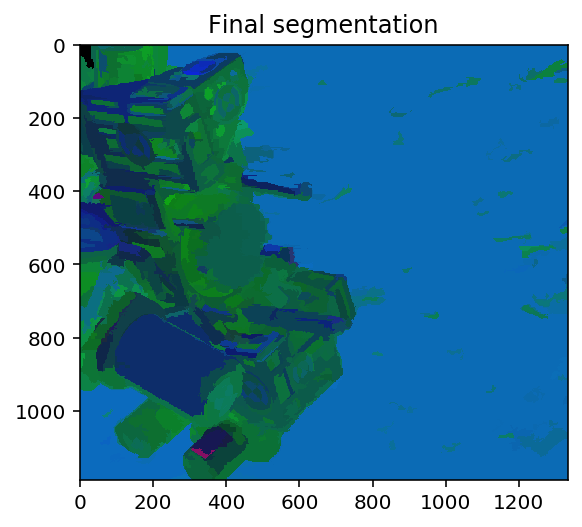

In [90]:
#sobel-operator region-based RAG/slic oversegmentation
image1=np.copy(Imag)
#image1 = filters.laplace(image1, ksize=100)
#plt.imshow(Imag)
image1 = filters.gaussian(image1, sigma=0.6, multichannel=True)
edges = filters.sobel(color.rgb2gray(image1))#find edges in an image using sobel operator
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Sobel edge map with prior filtering k=1')
labels = segmentation.felzenszwalb(image1, scale=100, sigma=0.3, min_size=200)
#plt.imshow(segmentation.mark_boundaries(image1,labels))
#labels = segmentation.slic(image1, compactness=100, n_segments=40,sigma=0.3)
g = graph.rag_boundary(labels, edges)

graph.show_rag(labels, g, image1)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(labels, g, thresh=0.012, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

graph.show_rag(labels, g, image1)
plt.title('RAG after hierarchical merging')
4
plt.figure()
out = color.label2rgb(labels2, image1, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Final segmentation')

plt.show()
#start_label problem

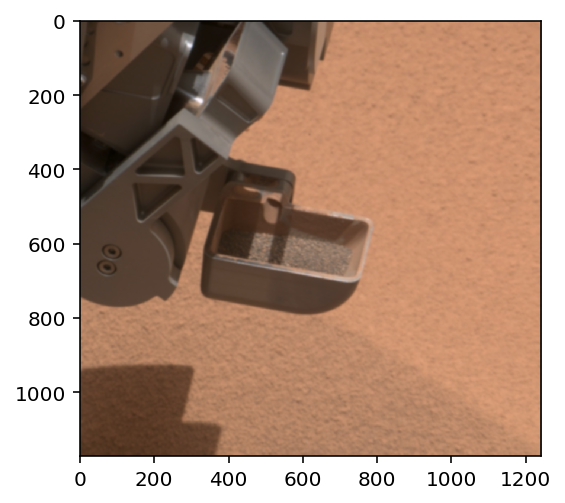

In [48]:
plt.imshow(Imag) 

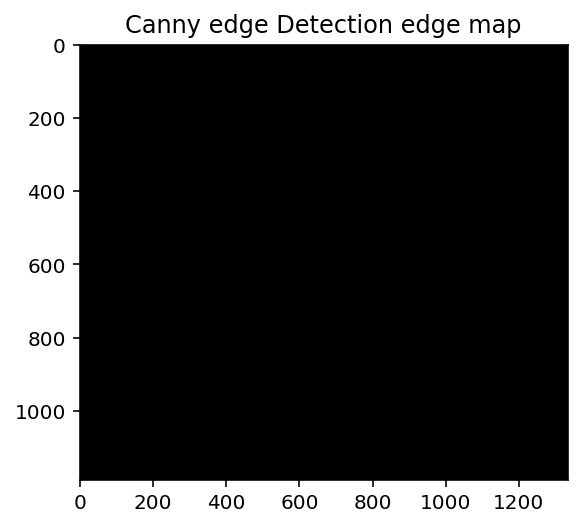

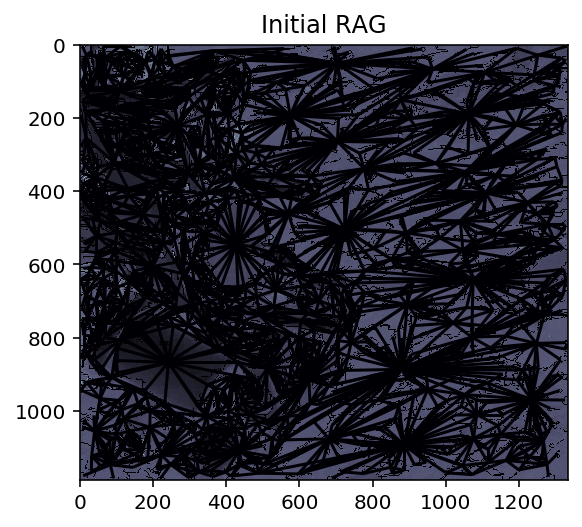

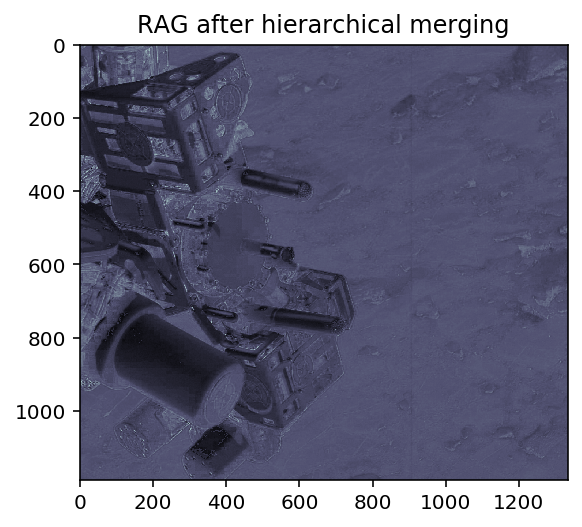

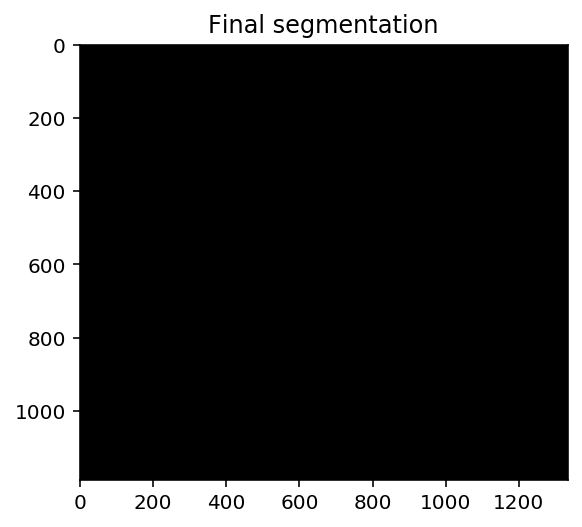

In [85]:
from skimage import feature
#from skimage.morphology import label
#canny-operator region-based RAG/Fenzenswalb oversegmentation
imag=np.copy(Imag)
edges = feature.canny(color.rgb2gray(imag),sigma=8)#find edges in an image using sobel operator
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Canny edge Detection edge map')
edges = edges.astype(np.float)
labels = segmentation.felzenszwalb(imag, scale=100,sigma=0.5, min_size=80)
#labels=skimage.img_to_float(labels)
g = graph.rag_boundary(labels, edges)

graph.show_rag(labels, g, imag)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

graph.show_rag(labels, g, imag)
plt.title('RAG after hierarchical merging')

plt.figure()
out = color.label2rgb(labels2, imag, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Final segmentation')

plt.show()
#start_label problem

In [108]:
#how canny operator works
#Apply Gaussian filter to smooth the image in order to remove the noise
#Find the intensity gradients of the image
#Apply non-maximum suppression to get rid of spurious response to edge detection
#Apply double threshold to determine potential edges
#Track edge by hysteresis: Finalize the detection of edges by suppressing all the 
#other edges that are weak and not connected to strong edges.

In [86]:
#implementing Marr-hildreth edge detector
def difference_of_gaussians(image, low_sigma, high_sigma=None, *,
                            mode='nearest', cval=0, multichannel=False,
                            truncate=4.0):
    image = img_as_float(image)
    low_sigma = np.array(low_sigma, dtype='float', ndmin=1)
    if high_sigma is None:
        high_sigma = low_sigma * 1.6
    else:
        high_sigma = np.array(high_sigma, dtype='float', ndmin=1)

    if multichannel is True:
        spatial_dims = image.ndim - 1
    else:
        spatial_dims = image.ndim

    if len(low_sigma) != 1 and len(low_sigma) != spatial_dims:
        raise ValueError('low_sigma must have length equal to number of'
                         ' spatial dimensions of input')
    if len(high_sigma) != 1 and len(high_sigma) != spatial_dims:
        raise ValueError('high_sigma must have length equal to number of'
                         ' spatial dimensions of input')

    low_sigma = low_sigma * np.ones(spatial_dims)
    high_sigma = high_sigma * np.ones(spatial_dims)

    if any(high_sigma < low_sigma):
        raise ValueError('high_sigma must be equal to or larger than'
                         'low_sigma for all axes')

    im1 = filters.gaussian(image, low_sigma, mode=mode, cval=cval,
                   multichannel=multichannel, truncate=truncate)

    im2 = filters.gaussian(image, high_sigma, mode=mode, cval=cval,
                           
                   multichannel=multichannel, truncate=truncate)

    return im1 - im2

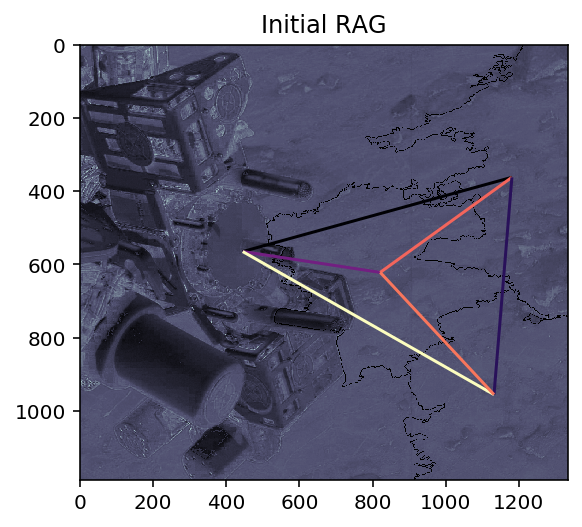

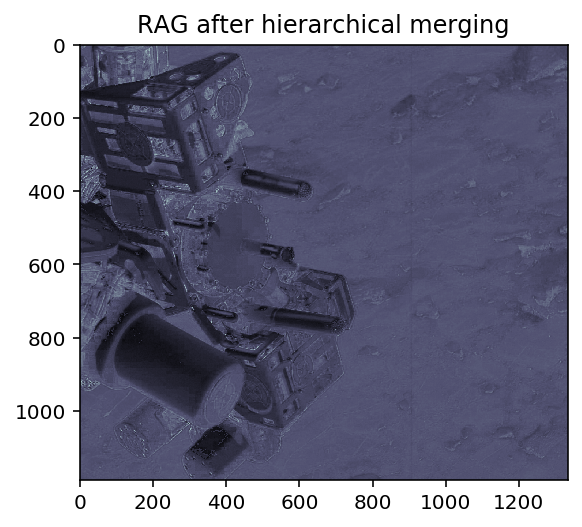

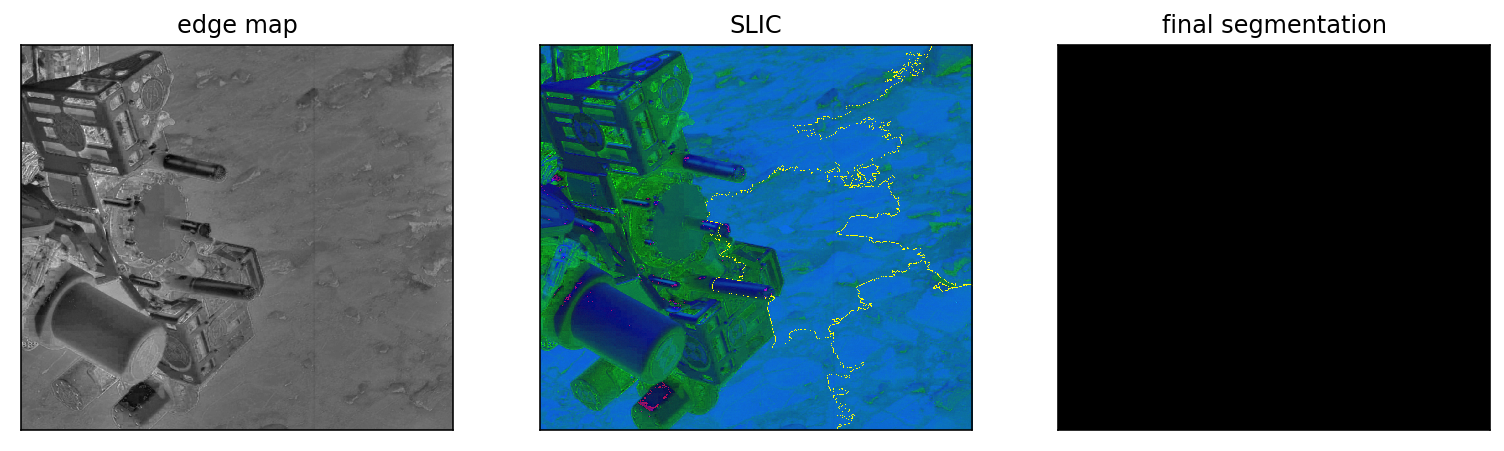

In [87]:
imag=np.copy(Imag)
edges = difference_of_gaussians(color.rgb2gray(imag),1,80,mode="wrap",multichannel=False)
#plt.imshow(edges, cmap=plt.cm.gray)
#plt.title('Marr-Hildreth Detection edge map')
labels = labels = segmentation.slic(imag, compactness=10, n_segments=20,sigma=0.1)
g = graph.rag_boundary(labels, edges)

graph.show_rag(labels, g, imag)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(labels, g, thresh=0.01, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

graph.show_rag(labels, g, imag)
plt.title('RAG after hierarchical merging')

#plt.figure()
out = color.label2rgb(labels2, imag, kind='avg', bg_label=0)
#plt.imshow(out)
#plt.title('Final segmentation')

#plt.show()
#start_label problem

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 5, forward=True)
fig.subplots_adjust(0.05, 0.05)

ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].set_title("edge map")
ax[1].imshow(segmentation.mark_boundaries(imag,labels))
ax[1].set_title("SLIC")
ax[2].imshow(out)
ax[2].set_title("final segmentation")


for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()